In [41]:
#importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 24
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set(font_scale = 2)
from sklearn.model_selection import train_test_split

# Imputing missing values and scaling values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#LIME
!pip install lime
import lime 
import lime.lime_tabular

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283845 sha256=e6e71fbe648d4715fb123b0e096dc60d2660b677d361727484e9e914c4803c3f
  Stored in directory: /Users/vishal/Library/Caches/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [7]:
graduate = pd.read_csv('../data/Admission_Predict_Ver1.1.csv')

### Exploratory Data Analysis

In [8]:
#dimensions of the dataset (initially 400, added 100 more entries using regex)
graduate.shape

(500, 9)

In [9]:
graduate.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [10]:
#dropping serial no column as we already have that information in the dataframe
graduate.drop(labels='Serial No.', axis=1, inplace=True)

In [11]:
#checking for the data types and if there are any missing values in the dataframe
graduate.info()

#there is no object datatype, so we needn't do any type conversions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [12]:
#column statistics
graduate.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [13]:
#renaming the name of the columns for easy reference
graduate.rename(columns = {'Serial No.': 'SerialNo', 'GRE Score': 'GRE', 'TOEFL Score': 'TOEFL', 'University Rating': 'UniversityRating', 'LOR ': 'LOR', 'Chance of Admit ': 'Chance'}, inplace=True)
graduate.columns

Index(['GRE', 'TOEFL', 'UniversityRating', 'SOP', 'LOR', 'CGPA', 'Research',
       'Chance'],
      dtype='object')

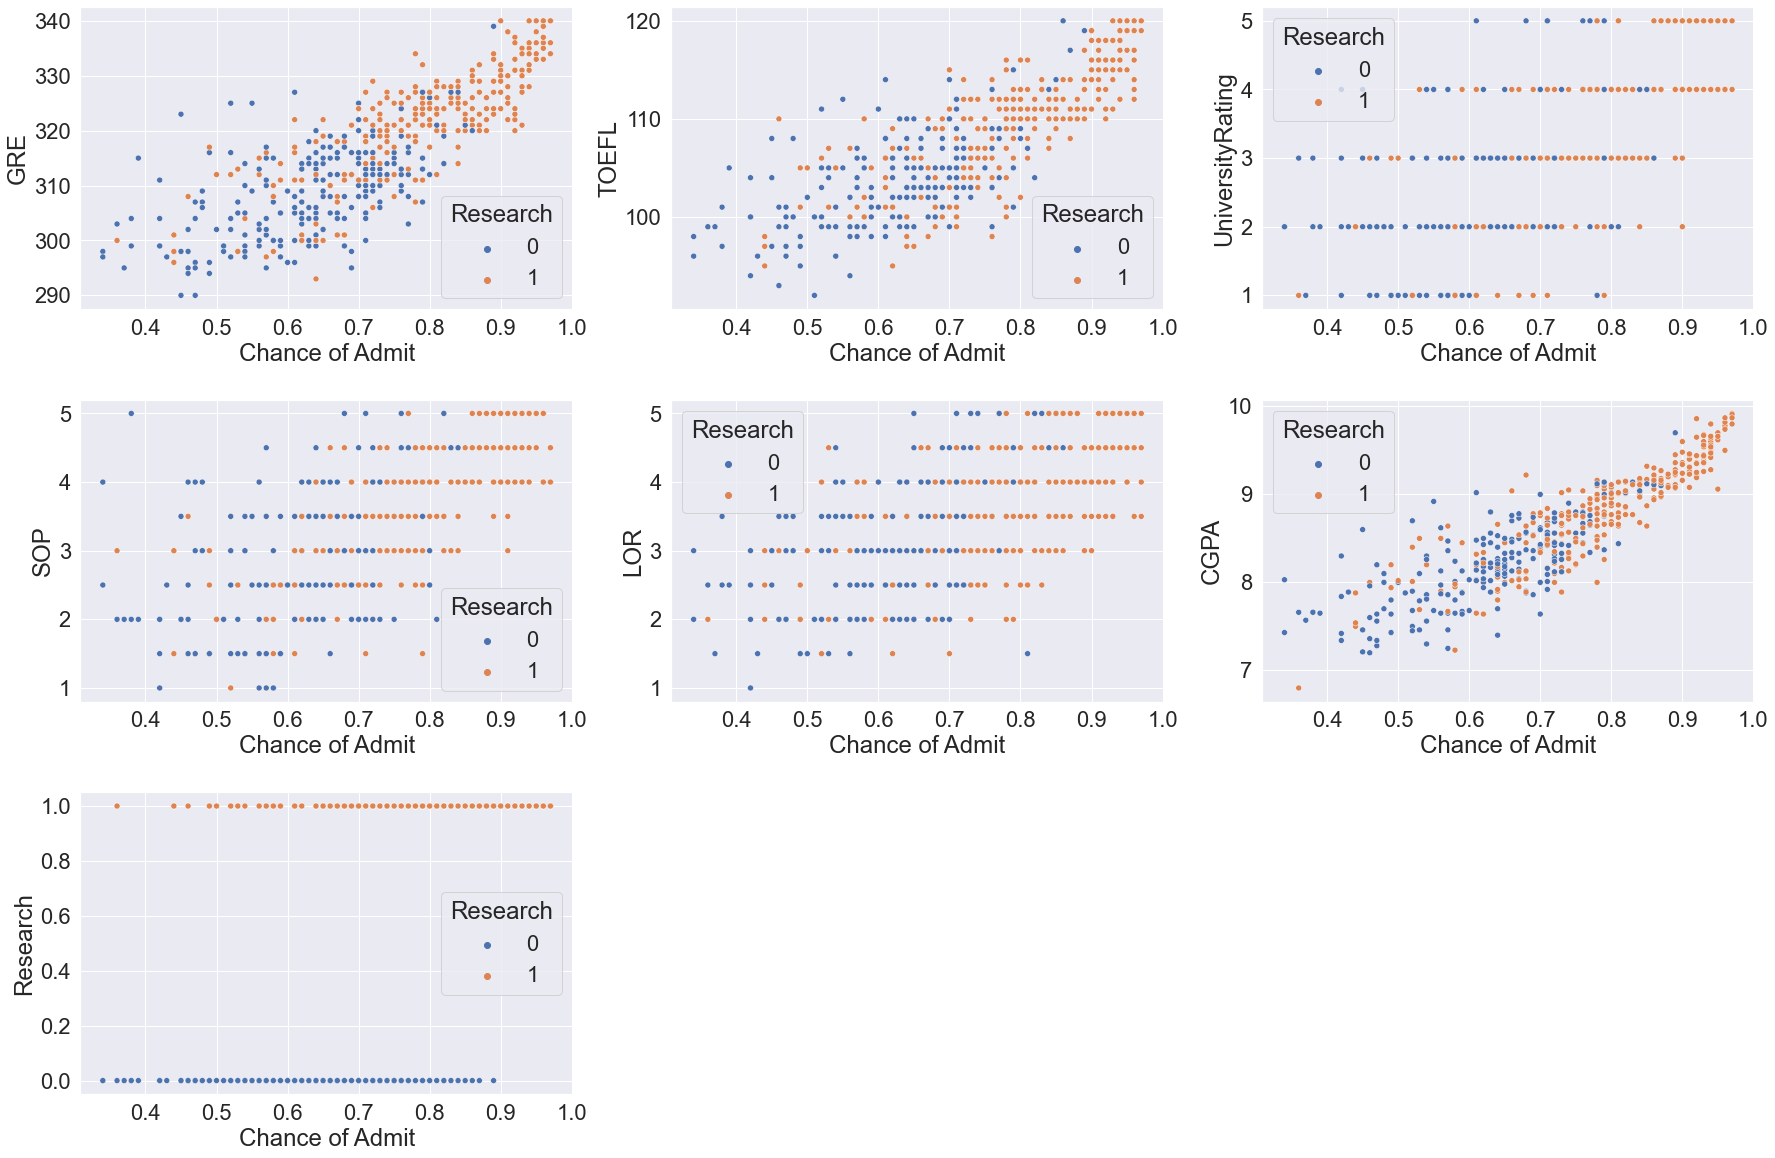

In [17]:
#Correlation between target (i.e. Chance) and other variables

fig = plt.figure(figsize=(30,20))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
for i in range(7):
    ax = fig.add_subplot(3, 3, i+1)
    sns.scatterplot(x=graduate['Chance'], y= graduate.iloc[:,i], hue=graduate.Research) #using research as the hue parameter
    plt.xlabel('Chance of Admit')
    plt.ylabel(graduate.columns[i])
    
#Conclusions from the plots:
#1. 'UniversityRating', 'SOP', 'LOR' and 'Research' is not scatterplot
#2. 'GRE', 'TOEFL' and 'CGPA' graphs have a linear behavior
#3. Prior Research experience leads to better chance of admission


In [18]:
#Removing Outliers 

for i in graduate.columns:
    # Calculating first and third quartile
    first_quartile = graduate[i].describe()['25%']
    third_quartile = graduate[i].describe()['75%']

    # Interquartile range
    iqr = third_quartile - first_quartile

    # Remove outliers
    graduate = graduate[(graduate[i] > (first_quartile - 3 * iqr)) & (graduate[i] < (third_quartile + 3 * iqr))]

In [21]:
#Quantifying correlation between target and features

correlations_data = graduate.corr()['Chance'].sort_values(ascending=False)
print(correlations_data)

#Conclusions:
#1. All features have positive influence on the target
#2. 3 basic influencer groups - high (CGPA, GRE, and TOEFL), intermediate (University Rating, SOP, and LOR) and low (Research)

Chance              1.000000
CGPA                0.882413
GRE                 0.810351
TOEFL               0.792228
UniversityRating    0.690132
SOP                 0.684137
LOR                 0.645365
Research            0.545871
Name: Chance, dtype: float64


In [22]:
#Train Test split

# Separate out the features and targets
features = graduate.drop(columns='Chance')
targets = pd.DataFrame(graduate['Chance'])

# Split into 70% training and 30% testing set
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(400, 7)
(100, 7)
(400, 1)
(100, 1)


In [23]:
# Function to calculate mean absolute error

def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [24]:
# Feature Scaling

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [29]:
# Train on the training features using the imputer object
imputer.fit(X_train)

# Transform both training data and testing data
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [30]:
# Convert y to one-dimensional array (vector)

y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [31]:
# Models to Evaluate

# We will compare five different machine learning models:

# 1 - Linear Regression
# 2 - Support Vector Machine Regression
# 3 - Random Forest Regression
# 4 - Gradient Boosting Regression
# 5 - K-Nearest Neighbors Regression

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [32]:
# Linear Regression

lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 0.0427


In [33]:
# SVM

svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 0.0591


In [35]:
# Random Forest

random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 0.0445


In [36]:
# Gradiente Boosting Regression

gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 0.0459


In [37]:
# KNN

knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 0.0478


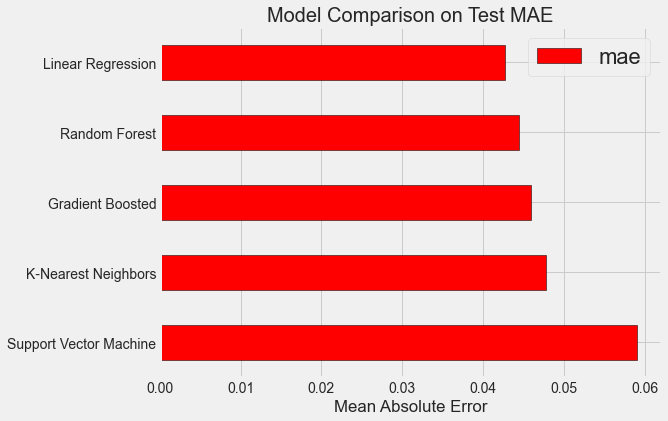

In [38]:
# Graph for comparison of all the models

plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

In [45]:
#Hyperparameter Tuning for Gradient Boosting Regressor using Random Search and 4-fold cross validation

# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [46]:
# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [47]:
# Fit on the training data
random_cv.fit(X_train, y_train)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [48]:
# getting all the corss validation results and sorting them by test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,...,split2_train_score,split3_train_score,mean_train_score,std_train_score
17,1.428966,0.045105,0.002040,0.000573,...,-0.029068,-0.032300,-0.030850,0.001231
19,3.589563,0.095582,0.002437,0.000052,...,-0.023699,-0.025848,-0.025276,0.001766
23,0.476863,0.007971,0.001065,0.000180,...,-0.027565,-0.029674,-0.028711,0.000802
24,0.861148,0.054673,0.000960,0.000013,...,-0.019549,-0.022820,-0.021447,0.001215
12,3.669583,0.095982,0.002526,0.000100,...,-0.016100,-0.017934,-0.017093,0.000980
20,18.811416,0.267771,0.006771,0.002727,...,-0.000004,-0.000011,-0.000009,0.000005
5,7.129921,0.298658,0.004680,0.000107,...,-0.015620,-0.019290,-0.017397,0.001299
8,59.080614,2.391820,0.020321,0.006358,...,-0.000160,-0.000070,-0.000094,0.000038
14,0.049815,0.003490,0.000978,0.000275,...,-0.033967,-0.036021,-0.034548,0.000912
6,75.623630,2.310650,0.019394,0.001857,...,-0.000201,-0.000072,-0.000093,0.000063


In [49]:
random_cv.best_estimator_

# The best gradient boosted model has the following hyperparameters:

# loss = lad
# n_estimators = 500
# max_depth = 2
# min_samples_leaf = 8
# min_samples_split = 6
# max_features = None 

GradientBoostingRegressor(loss='lad', max_depth=2, min_samples_leaf=8,
                          min_samples_split=6, n_estimators=500,
                          random_state=42)

In [51]:
# range of trees to evaluate
trees_grid = {'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]}

model = GradientBoostingRegressor(loss = 'lad', max_depth = 2,
                                  min_samples_leaf = 8,
                                  min_samples_split = 6,
                                  max_features = None,
                                  random_state = 42)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=trees_grid, cv = 4, 
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [52]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=4,
             estimator=GradientBoostingRegressor(loss='lad', max_depth=2,
                                                 min_samples_leaf=8,
                                                 min_samples_split=6,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750,
                                          800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [53]:
# Comparison between default model and best model
# Default model
default_model = GradientBoostingRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_

final_model

GradientBoostingRegressor(loss='lad', max_depth=2, min_samples_leaf=8,
                          min_samples_split=6, n_estimators=600,
                          random_state=42)

In [54]:
%%timeit -n 1 -r 5
default_model.fit(X_train, y_train)

48.6 ms ± 3.74 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [55]:
%%timeit -n 1 -r 5
final_model.fit(X_train, y_train)

954 ms ± 71.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [56]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 0.0462.
Final model performance on the test set:   MAE = 0.0435.


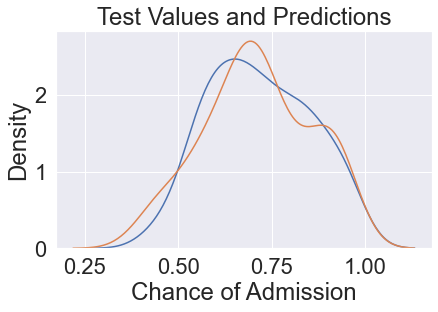

In [57]:
# plotting the distribution of true values on the test set and the predicted values on the test set.

# Train the model.
lr.fit(X_train, y_train)
    
# Make predictions and evalute.
model_pred = lr.predict(X_test)
    
figsize=(8, 8)

sns.kdeplot(model_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

plt.xlabel('Chance of Admission'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

In [58]:
model.fit(X_train, y_train)

GradientBoostingRegressor(loss='lad', max_depth=2, min_samples_leaf=8,
                          min_samples_split=6, random_state=42)

In [73]:
# Extract the feature importances into a dataframe
graduate_features = graduate.drop(labels='Chance', axis=1)
feature_results = pd.DataFrame({'feature': list(graduate_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,CGPA,0.520548
1,GRE,0.348582
2,TOEFL,0.054804
3,LOR,0.030340
4,SOP,0.020161
5,UniversityRating,0.015420
6,Research,0.010145


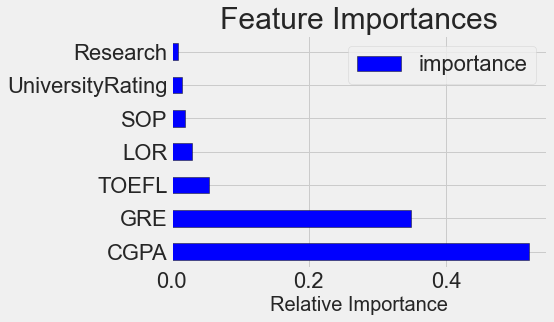

In [60]:
# Graph for feature importance

figsize=(12, 10)
plt.style.use('fivethirtyeight')

feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances', size = 30);

In [61]:
# Extracting names of the most important features
most_important_features = feature_results['feature'][:10]

indices = [list(graduate_features.columns).index(x) for x in most_important_features]

# Keeping only the most important features
X_train_reduced = X_train[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_train_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (400, 7)
Most important testing  features shape:  (100, 7)


In [63]:
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=2, max_features=None,
                                  min_samples_leaf=8, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_train_reduced, y_train)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 0.0429


### LIME for Explanations

In [64]:
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

### Protodash for Explanations

In [76]:
from sklearn.preprocessing import OneHotEncoder
!pip install aix360
from aix360.algorithms.protodash import ProtodashExplainer, get_Gaussian_Data
from aix360.datasets import CDCDataset

     |████████████████████████████████| 58.3 MB 286 kB/s eta 0:00:01
     |████████████████████████████████| 105.8 MB 1.1 MB/s eta 0:00:01
  Using cached image-1.5.33.tar.gz (15 kB)
  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
     |████████████████████████████████| 821 kB 924 kB/s eta 0:00:01
  Using cached shap-0.34.0.tar.gz (264 kB)
     |████████████████████████████████| 3.1 MB 273 kB/s eta 0:00:01
     |████████████████████████████████| 147.1 MB 901 kB/s eta 0:00:01
  Using cached lime-0.1.1.37.tar.gz (275 kB)
     |████████████████████████████████| 1.2 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 873 kB 560 kB/s eta 0:00:01
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached progressbar-2.5.tar.gz (10 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Using cached termcolor-1.1.0-

     |████████████████████████████████| 164 kB 1.0 MB/s eta 0:00:01
  Using cached scs-2.1.4.tar.gz (6.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 86 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 7.9 MB 599 kB/s eta 0:00:01
  Using cached sqlparse-0.4.2-py3-none-any.whl (42 kB)
  Using cached asgiref-3.4.1-py3-none-any.whl (25 kB)
     |████████████████████████████████| 121 kB 260 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for lime: filename=lime-0.1.1.37-py3-none-any.whl size=284276 sha256=26419bfd024747acb7db6c06f5db3e0ba5708bee345fb5d5eafbb4e502969815
  Stored in directory: /Users/vishal/Library/Caches/pip/wheels/5d/7a/8d/30e0ea15164fb80d5484e83ab991e188d6a9d8febfada307a6
  Created wheel for shap: filename=shap-0.34.0-cp37-cp

  copying xgboost/build/dmlc-core/CMakeFiles/dmlc.dir/src/io/local_filesys.cc.o.d -> build/lib/xgboost/build/dmlc-core/CMakeFiles/dmlc.dir/src/io
  copying xgboost/build/dmlc-core/CMakeFiles/dmlc.dir/src/io/recordio_split.cc.o.d -> build/lib/xgboost/build/dmlc-core/CMakeFiles/dmlc.dir/src/io
  creating build/lib/xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir
  copying xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir/DependInfo.cmake -> build/lib/xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir
  copying xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir/build.make -> build/lib/xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir
  copying xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir/cmake_clean.cmake -> build/lib/xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir
  copying xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir/compiler_depend.make -> build/lib/xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir
  copying xgboost/build/dmlc-core/CMakeFiles/dmlc_lint.dir/compiler_depend.ts -> build

  Created wheel for ecos: filename=ecos-2.0.7.post1-cp37-cp37m-macosx_10_9_x86_64.whl size=82456 sha256=8980c1237e6a35f11815fb34471aaaa1f0741fdf6f04dd4a2f0deb0f4a7b6cd0
  Stored in directory: /Users/vishal/Library/Caches/pip/wheels/70/e7/fd/4a4f957fc18a0f0407ca4b331c51e6a469c92efec58f732edf
  Created wheel for scs: filename=scs-2.1.4-cp37-cp37m-macosx_12_0_x86_64.whl size=117651 sha256=a47f6a9e6c88947594a1e59a804835a23dc0d4a31264eb63495de58fafc1fc62
  Stored in directory: /Users/vishal/Library/Caches/pip/wheels/d6/58/0b/a55ff6d4e2da4c9776e363a778ea13e4068037a7be82eb85e0
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19483 sha256=31b0870cd32703f6e94a64356cb5a3ced92babaa828d0bbd45a166d78bf7f186
  Stored in directory: /Users/vishal/Library/Caches/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12074 sha256=693a3df58e4393d79b4b6e2ad8afe6e847aaf70269dee41b0845cf

Using TensorFlow backend.
/Users/vishal/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vishal/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vishal/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vishal/anaconda3/lib/python3.7/site-packages/t

In [77]:
graduate_duplicate = pd.read_csv("../data/Admission_Predict_Ver1.1.csv")

In [79]:
# convert pandas dataframe to numpy
data = graduate_duplicate.to_numpy()

#sort the rows by sequence numbers in 1st column 
idx = np.argsort(data[:, 0])  
data = data[idx, :]

# replace nan's (missing values) with 0's
original = data
original[np.isnan(original)] = 0

# delete 1st column (sequence numbers)
original = original[:, 1:]

# one hot encode all features as they are categorical
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoded = onehot_encoder.fit_transform(original)

explainer = ProtodashExplainer()

# call protodash explainer
# S contains indices of the selected prototypes
# W contains importance weights associated with the selected prototypes 
(W, S, _) = explainer.explain(onehot_encoded, onehot_encoded, m=10) 

/Users/vishal/anaconda3/lib/python3.7/site-packages/cvxopt/coneprog.py:2111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'x' in initvals:
/Users/vishal/anaconda3/lib/python3.7/site-packages/cvxopt/coneprog.py:2116: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 's' in initvals:
/Users/vishal/anaconda3/lib/python3.7/site-packages/cvxopt/coneprog.py:2131: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'y' in initvals:
/Users/vishal/anaconda3/lib/python3.7/site-packages/cvxopt/coneprog.py:2136: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'z' in initvals:


In [80]:
# Display the prototypes along with their computed weights
inc_prototypes = graduate_duplicate.iloc[S, :].copy()
# Compute normalized importance weights for prototypes
inc_prototypes["Weights of Prototypes"] = np.around(W/np.sum(W), 2) 
inc_prototypes

,Serial No.,GRE Score,TOEFL Score,University Rating,...,CGPA,Research,Chance of Admit,Weights of Prototypes
371,372,324,110,3,...,9.22,1,0.89,0.11
36,37,299,106,2,...,8.40,0,0.64,0.10
89,90,316,109,4,...,8.76,1,0.74,0.11
421,422,321,112,3,...,8.95,1,0.77,0.10
358,359,314,105,2,...,7.64,0,0.70,0.11
483,484,304,103,5,...,7.92,0,0.71,0.11
481,482,323,107,4,...,8.48,1,0.78,0.10
447,448,320,108,3,...,8.97,1,0.84,0.09
256,257,309,99,3,...,8.56,0,0.76,0.10
419,420,308,102,2,...,7.98,1,0.58,0.08
